In [1]:
%matplotlib inline

In [2]:
from sparapy.radiosity_fast import DRadiosityFast
from sparapy.radiosity import Radiosity, DirectionalRadiosity
import sparapy.geometry as geo
import sparapy as sp
import cProfile
import pyfar as pf
import sofar as sf
import os
import tqdm
from datetime import datetime
import numpy as np
import tracemalloc

sample_walls = sp.testing.shoebox_room_stub(1, 1, 1)

In [3]:
def init_energy(rad, source_pos):
    rad.source = geo.SoundSource(source_pos, [1, 0, 0], [0, 0, 1])
    E_matrix = []
    for patches in rad.patch_list:
        patches.init_energy_exchange(
            rad.max_order_k, rad.ir_length_s, rad.source,
            sampling_rate=rad.sampling_rate, speed_of_sound=rad.speed_of_sound)
        E_matrix.append(patches.E_matrix)
    return E_matrix

def calc_form_factor(rad):
    if len(rad.patch_list) > 1:
        for patches in rad.patch_list:
            patches.calculate_form_factor(rad.patch_list)

def energy_exchange(rad):
    if len(rad.patch_list) > 1:
        for k in tqdm.tqdm(range(1, rad.max_order_k+1)):
            for patches in rad.patch_list:
                patches.calculate_energy_exchange(
                    rad.patch_list, k, speed_of_sound=rad.speed_of_sound,
                    E_sampling_rate=rad.sampling_rate)


In [4]:
gaussian = pf.samplings.sph_gaussian(sh_order=1)
gaussian = gaussian[gaussian.z>0]
sources = gaussian.copy()
receivers = gaussian.copy()
frequencies = pf.dsp.filter.fractional_octave_frequencies(
    1, (100, 1000))[0]
data = np.ones((sources.csize, receivers.csize, frequencies.size))
data = pf.FrequencyData(data, frequencies)
sofa = sf.Sofa('GeneralTF')
sofa.Data_Real = data.freq
sofa.Data_Imag = np.zeros_like(sofa.Data_Real)
sofa.N = data.frequencies
# Source and receiver data
sofa.EmitterPosition = sources.cartesian
sofa.EmitterPosition_Units = 'meter'
sofa.EmitterPosition_Type = 'cartesian'

sources_sph = sources.spherical_elevation
sources_sph = pf.rad2deg(sources_sph)
sofa.SourcePosition = sources_sph
sofa.SourcePosition_Units = 'degree, degree, metre'
sofa.SourcePosition_Type = 'spherical'

sofa.ReceiverPosition = receivers.cartesian
sofa.ReceiverPosition_Units = 'meter'
sofa.ReceiverPosition_Type = 'cartesian'

sofa.add_variable('ReceiverWeights', receivers.weights, 'double', 'R')
sofa.add_variable('SourceWeights', sources.weights, 'double', 'E')
sofa_path = os.path.join(os.getcwd(), 'test.sofa')
sf.write_sofa(sofa_path, sofa)


/Users/anne/anaconda3/envs/sparapy/lib/python3.12/site-packages/pyfar/samplings/samplings.py:300: PyfarDeprecationWarning: 'This function will be deprecated in pyfar 0.8.0 in favor of spharpy.samplings.gaussian.'
  warnings.warn((
/Users/anne/anaconda3/envs/sparapy/lib/python3.12/site-packages/pyfar/classes/coordinates.py:234: PyfarDeprecationWarning: 'This function will be changed in pyfar 0.8.0 to init(x, y, z).'
  warnings.warn((
/Users/anne/anaconda3/envs/sparapy/lib/python3.12/site-packages/pyfar/classes/coordinates.py:1050: PyfarDeprecationWarning: 'This function will be deprecated in pyfar 0.8.0 in favor of spharpy.samplings.SamplingSphere.'
  warnings.warn((
/Users/anne/anaconda3/envs/sparapy/lib/python3.12/site-packages/pyfar/classes/coordinates.py:264: PyfarDeprecationWarning: 'This function will be deprecated in pyfar 0.8.0 in favor of spharpy.samplings.SamplingSphere.'
  warnings.warn((


In [5]:
n_max = 3
repeat = 2
steps_names = [
    'create patches', 'init energy', 'form factor',
    'energy exchange', 'collect energy',
    ]
steps = len(steps_names)
fast_second = np.zeros((steps, n_max, repeat))
memory_fast = np.zeros((steps, n_max, repeat))
memory_slow = np.zeros((steps, n_max, repeat))
# memory_slow[:] = np.nan
slow = np.zeros((steps, n_max, repeat))
# slow[:] = np.nan
number_of_patches = np.zeros((n_max))

# run one time, to get complied.
radiosity = DRadiosityFast.from_polygon(sample_walls, 1)

radiosity.set_wall_scattering(
    np.arange(6), data, sources, receivers)
radiosity.set_air_attenuation(
    pf.FrequencyData(np.zeros_like(data.frequencies), data.frequencies))
radiosity.set_wall_absorption(
    np.arange(6),
    pf.FrequencyData(np.zeros_like(data.frequencies), data.frequencies))
radiosity.bake_geometry(algorithm='order')

radiosity.init_source_energy([0.5, 0.5, 0.5], algorithm='order')
max_order_k = 5
histogram = radiosity.calculate_energy_exchange_receiver(
    [0.5, 0.5, 0.5], 343, 1e-3, 1, algorithm='order',
    max_depth=max_order_k)
for i in range(n_max):
    max_size = 1/(2**i)
    start_loop = datetime.now()
    print(f'{datetime.now()} run({i+1}/{n_max}): {max_size}')
    # run fast two times
    for j in range(repeat):
        # create patches and add material
        tracemalloc.start()
        start = datetime.now()
        radiosity = DRadiosityFast.from_polygon(sample_walls, max_size)

        radiosity.set_wall_scattering(
            np.arange(6), data, sources, receivers)
        radiosity.set_air_attenuation(
            pf.FrequencyData(np.zeros_like(data.frequencies), data.frequencies))
        radiosity.set_wall_absorption(
            np.arange(6),
            pf.FrequencyData(np.zeros_like(data.frequencies), data.frequencies))
        delta = (datetime.now() - start)
        memory_fast[0, i, j] = tracemalloc.get_traced_memory()[1] # get peak memory
        tracemalloc.stop()
        fast_second[0, i, j] = (delta.seconds*1e6 + delta.microseconds)/repeat

        # form factor
        tracemalloc.start()
        start = datetime.now()
        radiosity.bake_geometry(algorithm='order')
        delta = (datetime.now() - start)
        memory_fast[2, i, j] = tracemalloc.get_traced_memory()[1] # get peak memory
        tracemalloc.stop()
        fast_second[2, i, j] = (delta.seconds*1e6 + delta.microseconds)/repeat

        # set energy
        tracemalloc.start()
        start = datetime.now()
        radiosity.init_source_energy([0.5, 0.5, 0.5], algorithm='order')
        delta = (datetime.now() - start)
        memory_fast[1, i, j] = tracemalloc.get_traced_memory()[1] # get peak memory
        tracemalloc.stop()
        fast_second[1, i, j] = (delta.seconds*1e6 + delta.microseconds)/repeat

        # energy exchange
        tracemalloc.start()
        start = datetime.now()
        histogram = radiosity.calculate_energy_exchange_receiver(
            [0.5, 0.5, 0.5], 343, 1e-3, 1,
            max_depth=max_order_k, algorithm='order')
        delta = (datetime.now() - start)
        memory_fast[3, i, j] = tracemalloc.get_traced_memory()[1] # get peak memory
        tracemalloc.stop()
        fast_second[3, i, j] = (delta.seconds*1e6 + delta.microseconds)/repeat

    number_of_patches[i] = radiosity.n_patches
    if i < 4:
        # Run old
        for j in range(repeat):
            # create patches
            tracemalloc.start()
            start = datetime.now()
            radiosity_old = DirectionalRadiosity(
                sample_walls, max_size, max_order_k, 1, sofa_path)
            delta = (datetime.now() - start)
            slow[0, i, j] = (delta.seconds*1e6 + delta.microseconds)/repeat
            memory_slow[0, i, j] = tracemalloc.get_traced_memory()[1] # get peak memory
            tracemalloc.stop()

            # init_energy
            tracemalloc.start()
            start = datetime.now()
            E_matrix = init_energy(radiosity_old, [0.5, 0.5, 0.5])
            delta = (datetime.now() - start)
            slow[1, i, j] = (delta.seconds*1e6 + delta.microseconds)/repeat
            memory_slow[1, i, j] = tracemalloc.get_traced_memory()[1] # get peak memory
            tracemalloc.stop()

            # form factor
            tracemalloc.start()
            start = datetime.now()
            calc_form_factor(radiosity_old)
            delta = (datetime.now() - start)
            slow[2, i, j] = (delta.seconds*1e6 + delta.microseconds)/repeat
            memory_slow[2, i, j] = tracemalloc.get_traced_memory()[1] # get peak memory
            tracemalloc.stop()

            # energy exchange
            tracemalloc.start()
            start = datetime.now()
            energy_exchange(radiosity_old)
            delta = (datetime.now() - start)
            slow[3, i, j] = (delta.seconds*1e6 + delta.microseconds)/repeat
            memory_slow[3, i, j] = tracemalloc.get_traced_memory()[1] # get peak memory
            tracemalloc.stop()

            # collect energy
            tracemalloc.start()
            start = datetime.now()
            receiver = sp.geometry.Receiver([0.5, 0.5, 0.5], [1, 0, 0], [0, 0, 1])
            radiosity_old.energy_at_receiver(receiver)
            delta = (datetime.now() - start)
            slow[4, i, j] = (delta.seconds*1e6 + delta.microseconds)/repeat
            memory_slow[4, i, j] = tracemalloc.get_traced_memory()[1] # get peak memory
            tracemalloc.stop()
    delta = (datetime.now() - start_loop)
    delta_seconds = (delta.seconds*1e6 + delta.microseconds)*1e-6
    print(f'{datetime.now()}   took {delta_seconds} seconds')


/var/folders/7q/_50y0lw50_x1j732_5yyyx7h0000gn/T/ipykernel_48820/3474773388.py:19: UserWarning: Gimbal lock detected. Setting third angle to zero since it is not possible to uniquely determine all angles.
  radiosity.set_wall_scattering(


2024-09-04 17:36:04.785452 run(1/3): 1.0


/var/folders/7q/_50y0lw50_x1j732_5yyyx7h0000gn/T/ipykernel_48820/3474773388.py:44: UserWarning: Gimbal lock detected. Setting third angle to zero since it is not possible to uniquely determine all angles.
  radiosity.set_wall_scattering(
/Users/anne/anaconda3/envs/sparapy/lib/python3.12/site-packages/pyfar/classes/coordinates.py:1050: PyfarDeprecationWarning: 'This function will be deprecated in pyfar 0.8.0 in favor of spharpy.samplings.SamplingSphere.'
  warnings.warn((
/Users/anne/git/_pyfar/sparapy/sparapy/radiosity.py:60: RuntimeWarning: invalid value encountered in divide
  real_size = size/patch_nums
/Users/anne/git/_pyfar/sparapy/sparapy/radiosity.py:1140: UserWarning: Gimbal lock detected. Setting third angle to zero since it is not possible to uniquely determine all angles.
  PatchesDirectional.from_sofa(
100%|██████████| 5/5 [00:00<00:00, 15.63it/s]
/Users/anne/git/_pyfar/sparapy/sparapy/radiosity.py:1235: RuntimeWarning: divide by zero encountered in scalar divide
  direct_s

2024-09-04 17:36:07.623088   took 2.8376379999999997 seconds
2024-09-04 17:36:07.623143 run(2/3): 0.5


100%|██████████| 5/5 [00:04<00:00,  1.05it/s]


2024-09-04 17:36:18.163240   took 10.540096 seconds
2024-09-04 17:36:18.163363 run(3/3): 0.25


100%|██████████| 5/5 [01:15<00:00, 15.18s/it]

2024-09-04 17:39:01.038552   took 162.875182 seconds


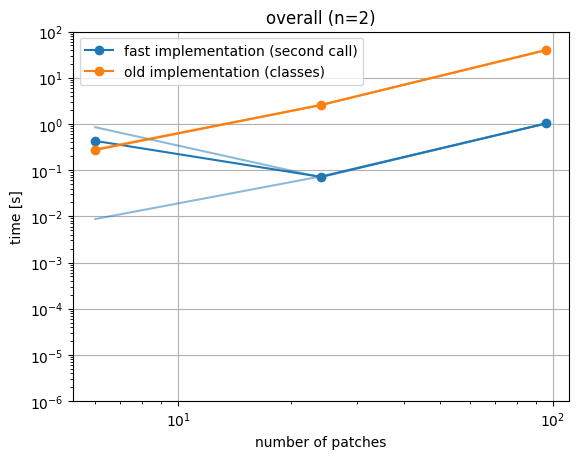

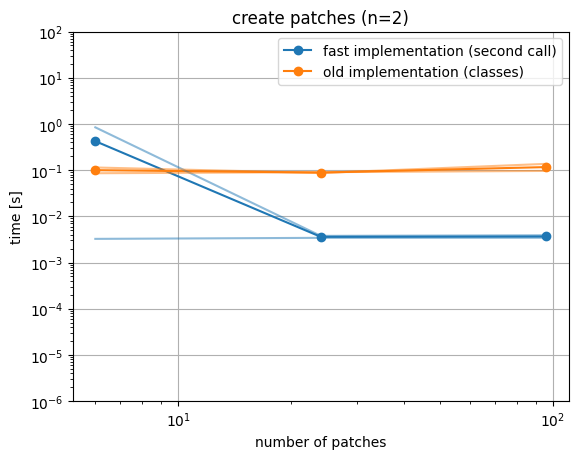

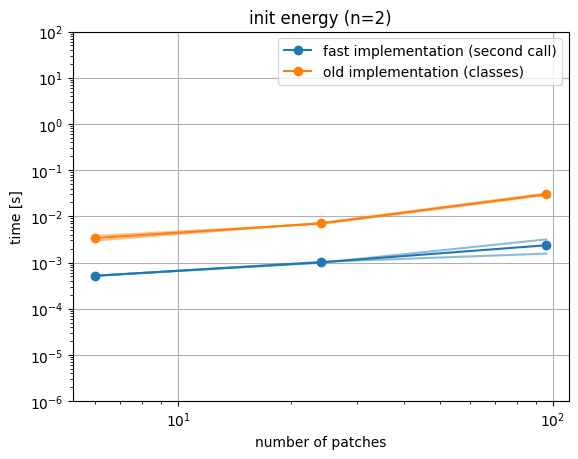

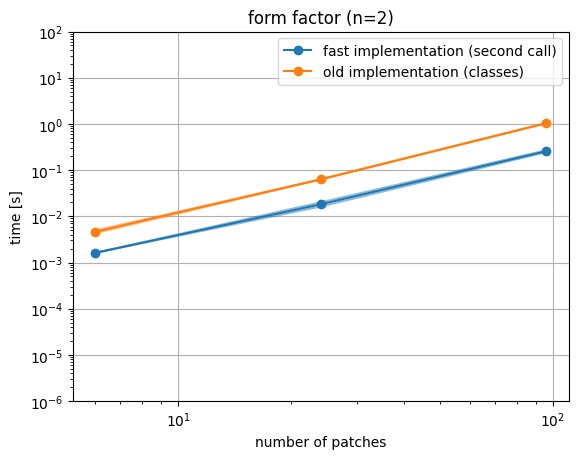

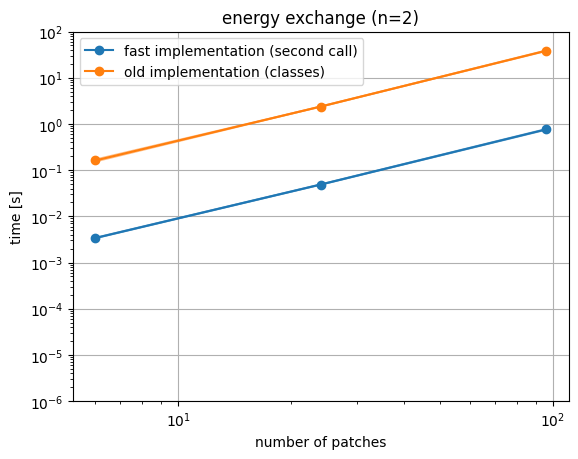

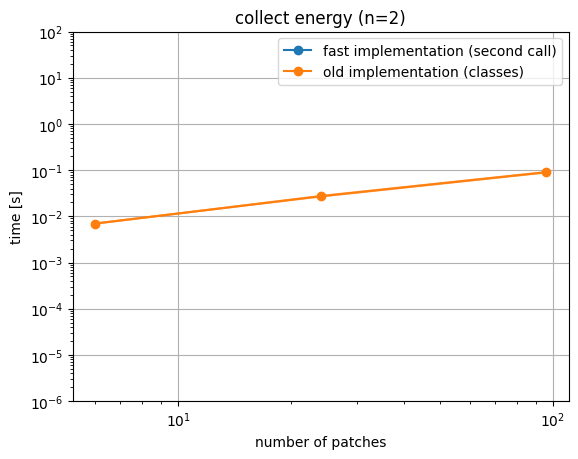

In [6]:
import matplotlib.pyplot as plt
slow[slow == 0] = np.nan
# plot time to compute
plt.figure()
ax = plt.gca()
ax.semilogy(
    number_of_patches, np.mean(np.sum(fast_second, axis=0)*1e-6, axis=-1),
    label='fast implementation (second call)', marker='o')
ax.semilogy(
    number_of_patches, np.mean(np.sum(slow, axis=0)*1e-6, axis=-1),
    label='old implementation (classes)', marker='o')
ax.semilogy(
    number_of_patches, np.sum(fast_second, axis=0)*1e-6, color='C0', alpha=0.5)
ax.semilogy(
    number_of_patches, np.sum(slow, axis=0)*1e-6, color='C1', alpha=0.5)
ax.grid()
ax.set_xscale('log')
ax.set_xlabel('number of patches')
ax.set_ylabel('time [s]')
ax.set_title(f'overall (n={repeat})')
ax.set_ylim([1e-6, 1e2])
plt.legend()

for i in range(steps):
    plt.figure()
    ax = plt.gca()

    ax.semilogy(
        number_of_patches, np.mean(fast_second[i]*1e-6, axis=-1),
        label='fast implementation (second call)', marker='o')
    ax.semilogy(
        number_of_patches, np.mean(slow[i]*1e-6, axis=-1),
        label='old implementation (classes)', marker='o')
    ax.semilogy(
        number_of_patches, fast_second[i]*1e-6, color='C0', alpha=0.5)
    ax.semilogy(
        number_of_patches, slow[i]*1e-6, color='C1', alpha=0.5)
    ax.grid()
    ax.set_xscale('log')
    ax.set_xlabel('number of patches')
    ax.set_ylabel('time [s]')
    ax.set_title(f'{steps_names[i]} (n={repeat})')
    ax.set_ylim([1e-6, 1e2])
    plt.legend()

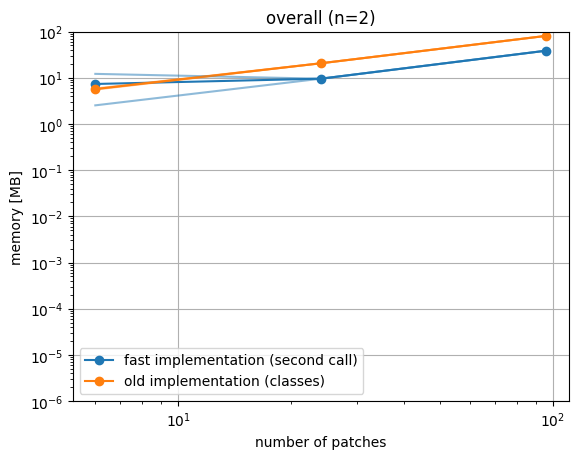

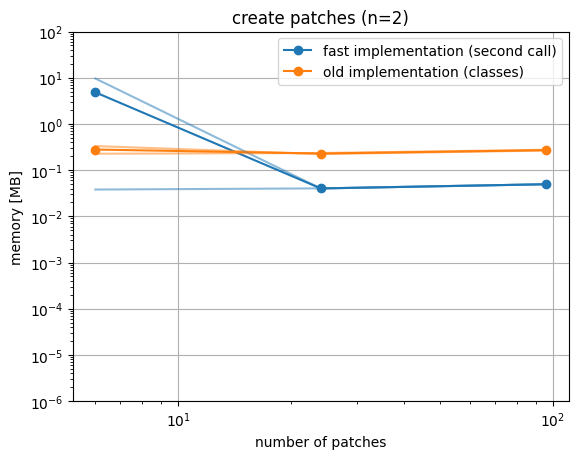

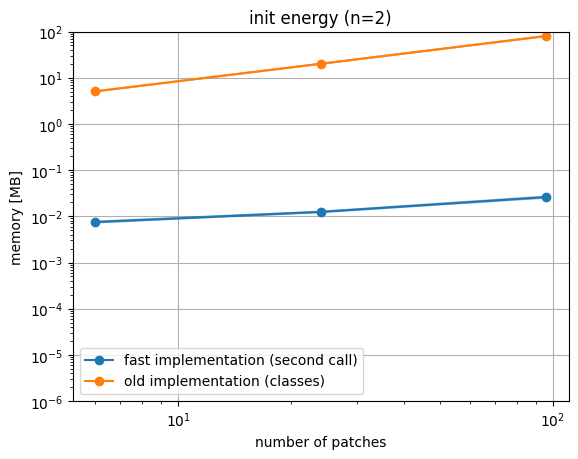

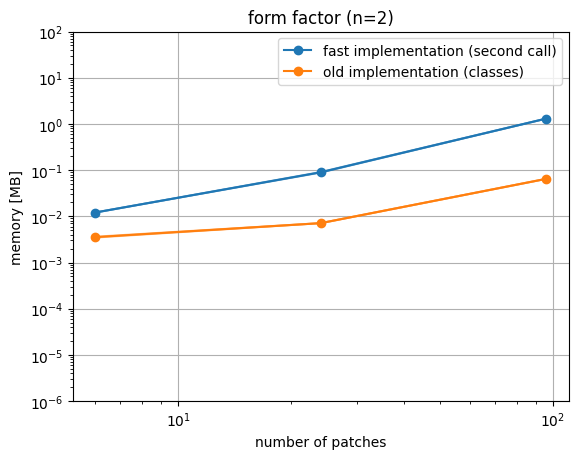

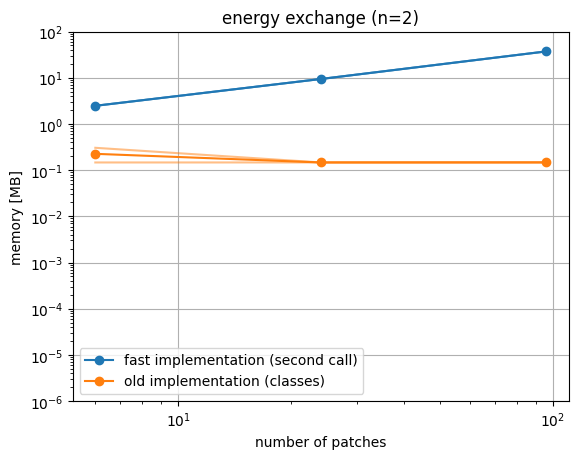

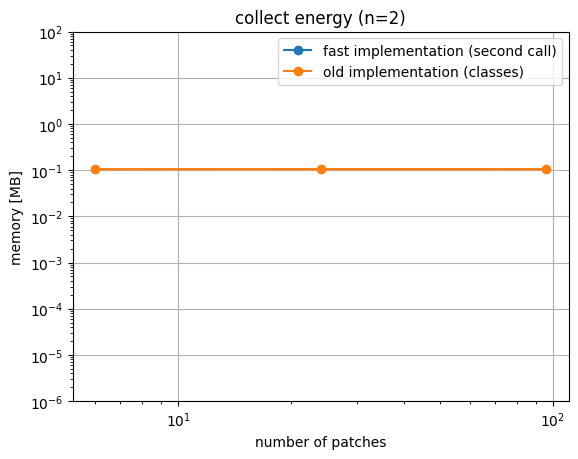

In [7]:
# plot memory consumption
memory_slow[memory_slow == 0] = np.nan

plt.figure()
ax = plt.gca()
ax.semilogy(
    number_of_patches, np.mean(np.sum(memory_fast, axis=0)*1e-6, axis=-1),
    label='fast implementation (second call)', marker='o')
ax.semilogy(
    number_of_patches, np.mean(np.sum(memory_slow, axis=0)*1e-6, axis=-1),
    label='old implementation (classes)', marker='o')
ax.semilogy(
    number_of_patches, np.sum(memory_fast, axis=0)*1e-6, color='C0', alpha=0.5)
ax.semilogy(
    number_of_patches, np.sum(memory_slow, axis=0)*1e-6, color='C1', alpha=0.5)
ax.grid()
ax.set_xscale('log')
ax.set_xlabel('number of patches')
ax.set_ylabel('memory [MB]')
ax.set_title(f'overall (n={repeat})')
ax.set_ylim([1e-6, 1e2])
plt.legend()

for i in range(steps):
    plt.figure()
    ax = plt.gca()

    ax.semilogy(
        number_of_patches, np.mean(memory_fast[i]*1e-6, axis=-1),
        label='fast implementation (second call)', marker='o')
    ax.semilogy(
        number_of_patches, np.mean(memory_slow[i]*1e-6, axis=-1),
        label='old implementation (classes)', marker='o')
    ax.semilogy(
        number_of_patches, memory_fast[i]*1e-6, color='C0', alpha=0.5)
    ax.semilogy(
        number_of_patches, memory_slow[i]*1e-6, color='C1', alpha=0.5)
    ax.grid()
    ax.set_xscale('log')
    ax.set_xlabel('number of patches')
    ax.set_ylabel('memory [MB]')
    ax.set_title(f'{steps_names[i]} (n={repeat})')
    ax.set_ylim([1e-6, 1e2])
    plt.legend()

In [8]:
r = np.sum(radiosity.form_factors==0) / radiosity.form_factors.size
print(f'ratio of zeros of form factors: {r*100:.2f}%')

ratio of zeros of form factors: 58.33%


In [9]:
%load_ext watermark
%watermark -v -m -iv

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.25.0

Compiler    : Clang 14.0.6 
OS          : Darwin
Release     : 23.5.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

sofar     : 1.1.4
matplotlib: 3.9.0
sparapy   : 0.1.0
numpy     : 1.26.4
pyfar     : 0.6.6
tqdm      : 4.66.4

